<a href="https://colab.research.google.com/github/neon0047/TimeSeriesAnalysis/blob/main/Energy_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib as mpl
from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

mpl.rcParams['figure.figsize'] = (15, 8)
mpl.rcParams['axes.grid'] = False

In [ ]:
import tensorflow as tf


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/energydata_complete.csv')

In [ ]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [ ]:
df.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [ ]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format = True)

In [ ]:
df_input = df[['Appliances','T1','RH_2','T_out','RH_out']]

In [ ]:
df_input.head()

,Appliances,T1,RH_2,T_out,RH_out
0,60,19.89,44.790000,6.600000,92.0
1,60,19.89,44.722500,6.483333,92.0
2,50,19.89,44.626667,6.366667,92.0
3,50,19.89,44.590000,6.250000,92.0
4,60,19.89,44.530000,6.133333,92.0


In [ ]:
df_input = df_input[~(df['Appliances'] >= 200)]
df_input.describe()

,Appliances,T1,RH_2,T_out,RH_out
count,17761.000000,17761.000000,17761.000000,17761.000000,17761.000000
mean,68.299645,21.687781,40.472599,7.312164,80.257760
std,30.517911,1.604704,4.061435,5.288624,14.762903
min,10.000000,16.790000,20.463333,-5.000000,24.000000
25%,50.000000,20.760000,37.933333,3.505556,71.333333
50%,60.000000,21.600000,40.560000,6.850000,84.333333
75%,80.000000,22.600000,43.326667,10.333333,92.000000
max,190.000000,26.200000,56.026667,26.100000,100.000000


In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input) 

In [ ]:
features = data_scaled
target = data_scaled[:,0]

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.20, random_state = 123, shuffle = False)

In [ ]:
win_length=1000
batch_size=30
num_features=df_input.shape[1]
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [ ]:
'''creating sequential model''' 

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 

model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) 


model.add(tf.keras.layers.Dropout(0.3)) 

model.add(tf.keras.layers.LSTM(64, return_sequences=False))

model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1000, 128)         68608     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1000, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000, 128)         131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 1000, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 1000, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [ ]:
 early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
 model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(), metrics=[tf.metrics.MeanAbsoluteError()])
 history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=False, callbacks=[early_stopping])

Epoch 1/50
441/441 [==============================] - 192s 422ms/step - loss: 0.0222 - mean_absolute_error: 0.1047 - val_loss: 0.0139 - val_mean_absolute_error: 0.0821
Epoch 2/50
441/441 [==============================] - 185s 419ms/step - loss: 0.0164 - mean_absolute_error: 0.0881 - val_loss: 0.0123 - val_mean_absolute_error: 0.0746
Epoch 3/50
441/441 [==============================] - 185s 420ms/step - loss: 0.0144 - mean_absolute_error: 0.0812 - val_loss: 0.0109 - val_mean_absolute_error: 0.0675
Epoch 4/50
441/441 [==============================] - 185s 420ms/step - loss: 0.0129 - mean_absolute_error: 0.0757 - val_loss: 0.0106 - val_mean_absolute_error: 0.0666
Epoch 5/50
441/441 [==============================] - 185s 421ms/step - loss: 0.0124 - mean_absolute_error: 0.0733 - val_loss: 0.0105 - val_mean_absolute_error: 0.0646
Epoch 6/50
441/441 [==============================] - 185s 419ms/step - loss: 0.0120 - mean_absolute_error: 0.0716 - val_loss: 0.0104 - val_mean_absolute_error:

In [ ]:
model.evaluate_generator(test_generator, verbose = 0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.010052129626274109, 0.06416329741477966]

In [ ]:
predictions = model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [ ]:
predictions

array([[0.31513983],
       [0.29524246],
       [0.4891898 ],
       ...,
       [0.5621918 ],
       [0.4903054 ],
       [0.5189107 ]], dtype=float32)

In [ ]:
x_test[win_length:,1:].shape

(2553, 4)

In [ ]:
df_pred = pd.concat([pd.DataFrame(predictions),pd.DataFrame(x_test[win_length:,1:])], axis = 1)

In [ ]:
rev_trans = scaler.inverse_transform(df_pred)

In [ ]:
df_final = df_input[predictions.shape[0]*-1:]

In [ ]:
df_final.count()

Appliances    2553
T1            2553
RH_2          2553
T_out         2553
RH_out        2553
dtype: int64

In [ ]:
df_final['App_Pred'] = rev_trans[:,0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_final

,Appliances,T1,RH_2,T_out,RH_out,App_Pred
16939,60,24.166667,39.233333,16.283333,70.833333,66.725169
16941,130,24.260000,37.493333,17.250000,66.500000,63.143643
16943,70,24.290000,35.550000,18.216667,62.166667,98.054165
16946,60,24.390000,33.433333,19.333333,57.666667,80.497959
16947,80,24.390000,33.226667,19.650000,56.500000,69.867050
...,...,...,...,...,...,...
19727,120,25.500000,42.320000,22.966667,55.000000,126.773918
19728,110,25.600000,42.528571,23.000000,55.000000,109.848599
19729,90,25.533333,42.534000,22.866667,55.333333,111.194521
19730,100,25.566667,42.025714,22.733333,55.666667,98.254971


# Actual vs Predicted value

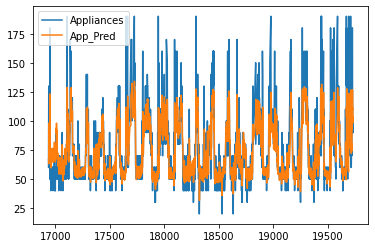

In [ ]:
df_final[['Appliances','App_Pred']].plot()

# Mean Absolute Percentage Error

In [ ]:
Appliances = df_final['Appliances'].tolist();
App_Pred = df_final['App_Pred'].tolist();
tf.keras.losses.mean_absolute_percentage_error(Appliances, App_Pred)

<tf.Tensor: shape=(), dtype=float32, numpy=15.62645>